# Intro

Notebook trains Banksformer models and generates sythetic data.   
Parameters for generating data (seq_len, number of seqs) are near bottom (Under "Generate Full dataset")

In [1]:
import logging
import os
import sys
import time
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import seaborn as sns

In [2]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

# SETUP DATA

### Set input dataset and nb_id

In [3]:
from field_config import CLOCK_DIMS, get_field_info, DATA_KEY_ORDER, LOSS_TYPES

DATA_KEY_ORDER is ['tcode_num', 'dow', 'month', 'day', 'dtme', 'td_sc', 'log_amount_sc']
LOSS_TYPES are: day - scce, dtme - scce, dow - scce, month - scce, td_sc - pdf, log_amount_sc - pdf, tcode_num - scce
If this is not correct, edit field_config.py and re-run notebook


In [4]:
ds_suffix = "-uk"
nb_id = "cond"

### Load training data

In [5]:
inp_tensor = np.load(f"stored_data/inp_tensor-{ds_suffix}.npy")
tar_tensor = np.load(f"stored_data/tar_tensor-{ds_suffix}.npy")
attributes = np.load(f"stored_data/attributes-{ds_suffix}.npy")

inp_tensor.shape, tar_tensor.shape, attributes.shape

((6983, 21, 54), (6983, 20, 7), (6983,))

In [6]:
n_seqs, n_steps, n_feat_inp = inp_tensor.shape
n_feat_tar = tar_tensor.shape[2]

In [7]:
from my_lib.encoding import load_data_encoder
data_encoder = load_data_encoder(ds_suffix)

### Split and create tf dataset

In [8]:
from sklearn.model_selection import train_test_split

x_tr, x_cv, inds_tr, inds_cv, targ_tr, targ_cv = train_test_split(
    inp_tensor, np.arange(n_seqs), tar_tensor, test_size=0.2)

In [9]:
ds_tr = tf.data.Dataset.from_tensor_slices((x_tr.astype(np.float32), targ_tr.astype(np.float32)))
ds_cv = tf.data.Dataset.from_tensor_slices((x_cv.astype(np.float32), targ_cv.astype(np.float32)))

ds_tr

2022-06-29 11:56:27.712714: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<TensorSliceDataset element_spec=(TensorSpec(shape=(21, 54), dtype=tf.float32, name=None), TensorSpec(shape=(20, 7), dtype=tf.float32, name=None))>

In [10]:
from my_lib.transformer_core import make_batches

BUFFER_SIZE = ds_tr.cardinality().numpy()


# Training

## Loss

In [11]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return  -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)


In [12]:
def log_normal_pdf_gen(sample, mean, logvar, raxis=1):
    log2pi = tf.cast(tf.math.log(2. * np.pi), tf.float64)
    return  -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)


In [13]:

from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError, SparseCategoricalCrossentropy


loss_scce_logit = SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

loss_scce_probit = SparseCategoricalCrossentropy(
    from_logits=False, reduction='none')

loss_mse = MeanSquaredError(reduction='none')



def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(tf.reduce_sum(seq, axis=2), 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)



def loss_function(real, pred):
    loss_parts = []
    loss_parts_weighted = []

    for k, k_pred in pred.items():

        st = FIELD_STARTS_TAR[k]
        end = st + FIELD_DIMS_TAR[k]
        loss_type = LOSS_TYPES[k]
        

        if loss_type == "scce":
            loss_ = loss_scce_logit(real[:, :, st:end], k_pred)
        elif loss_type == "clock":
            loss_ = loss_scce_probit(real[:, :, st:end], clock_to_onehot(k, k_pred))
        elif loss_type == "mse":
            loss_ = loss_mse(real[:, :, st:end], k_pred)
        elif loss_type == "pdf":
            loss_ = -log_normal_pdf(real[:, :, st:end], k_pred[:,:,0:1], k_pred[:,:,1:2])[:,:,0]
        else:
            raise Exception(f"Invalid loss type! Got loss type = {loss_type} with key = {k}. Check field_config.py for loss types")
            

        mask = tf.math.logical_not(tf.math.equal(tf.reduce_sum(real, axis=2), 0))
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_ = tf.reduce_sum(loss_)/tf.reduce_sum(mask) 

        loss_parts.append(loss_)
        loss_parts_weighted.append(loss_ * LOSS_WEIGHTS[k])

    return tf.reduce_sum(loss_parts_weighted), loss_parts




In [14]:
from my_lib.encoding import bulk_encode_time_value

EPS_CLOCKP = 0.01

CLOCKS = {}
for k, val in CLOCK_DIMS.items():
    CLOCKS[k] = tf.constant(bulk_encode_time_value(np.arange(val), val), dtype=tf.float32)

def clock_to_probs(pt, pts):
    
    ds = tf.constant(pts) - pt
    sq_ds = np.sum(tf.square(ds+EPS_CLOCKP), axis=1)
    raw_ps = 1/ sq_ds   
    
    return raw_ps / np.sum(raw_ps)



def clock_to_onehot(k, vals):
    orig_shape = vals.shape

    vals = tf.reshape(vals, (-1, orig_shape[-1]))

    return np.array([clock_to_probs(p, CLOCKS[k]) for p in vals]).reshape(*orig_shape[:-1], -1)   


CLOCK_DIMS

{'day': 31, 'dtme': 31, 'dow': 7, 'month': 12}

## Set Banksformer configs

In [15]:
ACTIVATIONS = {
    "td_sc": "relu",
    "log_amount_sc": "relu"
}

In [16]:
config = {}
FIELD_DIMS_IN, FIELD_STARTS_IN, FIELD_DIMS_TAR, FIELD_STARTS_TAR, FIELD_DIMS_NET, FIELD_STARTS_NET = get_field_info(ds_suffix)

config["ORDER"] = DATA_KEY_ORDER
config["FIELD_STARTS_IN"] = FIELD_STARTS_IN
config["FIELD_DIMS_IN"] = FIELD_DIMS_IN
config["FIELD_STARTS_NET"] = FIELD_STARTS_NET
config["FIELD_DIMS_NET"] = FIELD_DIMS_NET


config["ACTIVATIONS"] = ACTIVATIONS



## Training Loop 

In [17]:
from my_lib.BanksformerGen import Transformer
import pickle 


all_models = []
for_df = []


def to_num(x):
    try: return int(x)
    except: return float(x)

    
def id_str_to_folder(id_str):
    return id_str.replace(".", "__")
beta = 1


# moredate
LOSS_WEIGHTS_OLD = {
 'td_sc':1.,
 'year': 0.5,
 'month': 0.15,
 'day': 0.25,
 'dow': 0.1,
 'tcode_num': 1.,
 'log_amount_sc': 2.}


LOSS_WEIGHTS_0 = {
 'td_sc':1.,
 'month': 0.015,
 'day': 0.025,
 'dow': 0.01,
 'tcode_num': 1.,
 'log_amount_sc': 2.}



LOSS_WEIGHTS_MID = {
 'td_sc':1.,
 'month': 0.07,
 'day': 0.1,
 'dow': 0.04,
 'tcode_num': 1.,
 'log_amount_sc': 2.}



lws = [(LOSS_WEIGHTS_0, "0"), (LOSS_WEIGHTS_OLD, "moredate")]

# lws = [(LOSS_WEIGHTS_MID, "mid")]

td_loss_fns = [(loss_mse, "loss_mse")]


EPOCHS = 80
EARLY_STOP = 2

num_layers_enc = None
dropout_rate = 0.1
dr = dropout_rate
opt_name = "adam"
# td_loss_fn = loss_mse


## Tuning these ! 
d_model = 128
num_layers_dec = 4
num_heads = 2
bs = 64
# lws # above


LOSS_WEIGHTS, lwi = lws[0]


dff = d_model



for i in range(3):


                start = time.time()


                print(datetime.datetime.now().strftime("%H:%M"))


                transformer = Transformer(
                    num_layers_enc=num_layers_enc, num_layers_dec=num_layers_dec,
                    d_model=d_model,
                    num_heads=num_heads,
                    dff=dff,
                    maximum_position_encoding=256,
                   net_info = None, 
                    inp_dim = n_feat_inp,
                    final_dim= None,
                    config=config,
                    rate=dr)

                optimizer = tf.keras.optimizers.Adam()
                transformer.optimizer =  optimizer


                train_batches = make_batches(ds_tr, BUFFER_SIZE, bs)


                transformer.loss_function = loss_function
                LOSS_WEIGHTS["dtme"] = LOSS_WEIGHTS["day"]

                LOSS_WEIGHTS["k_symbol_num"] = LOSS_WEIGHTS["tcode_num"]
                LOSS_WEIGHTS["operation_num"] = LOSS_WEIGHTS["tcode_num"]
                LOSS_WEIGHTS["type_num"] = LOSS_WEIGHTS["tcode_num"]
                transformer.LOSS_WEIGHTS = LOSS_WEIGHTS

                id_str = f"v2b__nld_{num_layers_dec}-dm_{d_model}-nh_{num_heads}-i_{i}-dr_{dr}-opt_{opt_name}-lwi_{lwi}-bs_{bs}"

                print("Begin running", id_str)
                transformer.id_str = id_str


                all_models.append(transformer)
                transformer.compile()


                transformer.checkpoint_path = f"./checkpoints/{id_str_to_folder(transformer.id_str)}-{ds_suffix}-{nb_id}"
                transformer.ckpt = tf.train.Checkpoint(transformer=transformer,
                                           optimizer=optimizer)
                transformer.ckpt_manager = tf.train.CheckpointManager(transformer.ckpt, 
                                                                      transformer.checkpoint_path, max_to_keep=EARLY_STOP)

                if transformer.ckpt_manager.latest_checkpoint:
                    transformer.ckpt.restore(transformer.ckpt_manager.latest_checkpoint)
                    print('Latest checkpoint restored!!')    
                    continue


                transformer.fit(train_batches, x_cv, targ_cv, epochs= EPOCHS, early_stop=EARLY_STOP, print_every=50, ckpt_every = 1)

                transformer.fit_time = time.time() - start
                transformer.results["fit_time"] = transformer.fit_time 

                with open(f"training_history/{id_str_to_folder(transformer.id_str)}.pickle", "wb") as f:
                    pickle.dump(transformer.results, f) 
                    print("Wrote transformer.results to", f.name)


                for_df.append((num_layers_dec, d_model, num_heads, i, dr, beta, dff,
                               np.min(transformer.results["val_loss"]), opt_name, transformer.id_str))




11:56
Begin running v2b__nld_4-dm_128-nh_2-i_0-dr_0.1-opt_adam-lwi_0-bs_64
Epoch 1 Batch 0 Loss 12.0507
Epoch 1 Batch 50 Loss 10.5404
Epoch 1 Loss 10.1559
** on validation data loss is 9.3292
Not recording acc: 'Transformer' object has no attribute 'acc_function'
Time taken for 1 epoch: 98.31 secs

Saving checkpoint for epoch 1 at ./checkpoints/v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--uk-cond/ckpt-1
Epoch 2 Batch 0 Loss 9.3089
Epoch 2 Batch 50 Loss 9.2354
Epoch 2 Loss 8.9652
** on validation data loss is 7.0959
Time taken for 1 epoch: 100.06 secs

Saving checkpoint for epoch 2 at ./checkpoints/v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--uk-cond/ckpt-2
Epoch 3 Batch 0 Loss 7.0371
Epoch 3 Batch 50 Loss 7.2459
Epoch 3 Loss 7.1521
** on validation data loss is 6.8766
Time taken for 1 epoch: 114.98 secs

Saving checkpoint for epoch 3 at ./checkpoints/v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--uk-cond/ckpt-3
Epoch 4 Batch 0 Loss 6.7960
Epoch 4 Batch

### Results

In [18]:
df = pd.DataFrame.from_records(for_df, columns=['num_layers_dec', 'd_model', 'num_heads', 'i', "dr", "beta", "dff",
                                                "val loss", "opt name","id_str"]).sort_values("val loss")

In [19]:
with pd.option_context('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", None):
    display(df.sort_values("val loss"))

,num_layers_dec,d_model,num_heads,i,dr,beta,dff,val loss,opt name,id_str
2,4,128,2,2,0.1,1,128,5.259680,adam,v2b__nld_4-dm_128-nh_2-i_2-dr_0.1-opt_adam-lwi_0-bs_64
0,4,128,2,0,0.1,1,128,5.291912,adam,v2b__nld_4-dm_128-nh_2-i_0-dr_0.1-opt_adam-lwi_0-bs_64
1,4,128,2,1,0.1,1,128,5.424337,adam,v2b__nld_4-dm_128-nh_2-i_1-dr_0.1-opt_adam-lwi_0-bs_64


In [20]:
transformer = all_models[0]

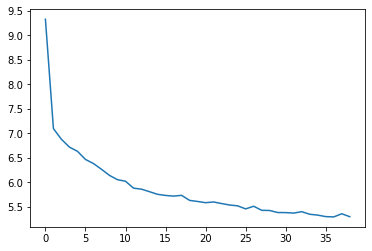

In [21]:
plt.plot(np.array(transformer.results["val_loss"]))

# Generate  
Warning: Code below is not nice and should be refactored

In [22]:
MAX_YEARS_SPAN = 15

## Set up

In [23]:
from my_lib.encoding import encode_time_value
#, decode_time_value

clocks = {}
for max_val in [7, 31, 12]:
    cmd = f"clocks[{max_val}] = np.array([encode_time_value(val, {max_val}) for val in range({max_val})])"
    print("Running", cmd)
    exec(cmd)
    
clocks.keys()

Running clocks[7] = np.array([encode_time_value(val, 7) for val in range(7)])
Running clocks[31] = np.array([encode_time_value(val, 31) for val in range(31)])
Running clocks[12] = np.array([encode_time_value(val, 12) for val in range(12)])


dict_keys([7, 31, 12])

In [24]:
START_DATE = data_encoder.START_DATE 
START_DATE = data_encoder.START_DATE.split()[0]

import calendar
get_dtme = lambda d: calendar.monthrange(d.year, d.month)[1] - d.day

if type(START_DATE) == str:
    START_DATE = datetime.datetime.strptime(START_DATE, "%Y-%m-%d").date()
    
    

END_DATE = START_DATE.replace(year = START_DATE.year+ MAX_YEARS_SPAN)

ALL_DATES = [START_DATE + datetime.timedelta(i) for i in range((END_DATE - START_DATE).days)]

# AD = np.array([(d.month % 12, d.day % 31, d.weekday() % 7, i, d.year) for i, d in enumerate(ALL_DATES)])
AD = np.array([(d.month % 12, d.day % 31, d.weekday() % 7, i, d.year, get_dtme(d)) for i, d in enumerate(ALL_DATES)])



In [25]:
from my_lib.transformer_core import create_masks

    
def reencode_net_prediction(net_name, predictions):
    
    date_info = {'month':12, 'day':31, 'dtme':31, 'dow':7}
    batch_size = predictions.shape[0]
    

    if net_name in ['balance', 'td_sc', 'dss', "log_amount_sc"]:
        return predictions[:, :, 0:1]


    elif net_name in date_info.keys():
        dim = FIELD_DIMS_NET[net_name]
        choices = np.arange(dim)

        ps = tf.nn.softmax(predictions, axis=2).numpy().reshape(-1, dim)

        
        choosen =  np.array([np.random.choice(choices, p=p) for p in ps])
        
        x = bulk_encode_time_value(choosen, max_val=dim)
        
        return np.reshape(x, newshape=(batch_size, -1, 2))

    
    elif "_num" in net_name:
        dim = FIELD_DIMS_NET[net_name]
        choices = np.arange(dim)

        ps = tf.nn.softmax(predictions, axis=2).numpy().reshape(-1, dim)
        

        
        choosen =  np.reshape([np.random.choice(choices, p=p) for p in ps], newshape=(batch_size, -1))
        

        return tf.one_hot(choosen, depth=dim)
    
    else:
        raise Exception(f"Got invalid net_name: {net_name}")

days_per_month = np.array([(datetime.date(1990, month, 1) - datetime.timedelta(1)).day for month in range(1,13)]) # 0 = dec


@np.vectorize
def get_short_name(tcode):
    return short_names[tcode]


@np.vectorize
def get_date_str(mm, dd):
    return f"{mm:02d}/{dd:02d}"


def bulk_decode(seqs, start_dates, return_single_df=False, return_df_list=False):
    

    ages = seqs[:, 0, :] * data_encoder.ATTR_SCALE
    seqs = seqs[:, 1:, :]
    assert np.sum(np.diff(ages)) == 0, f"Bad formating, expected all entries same in each row, got {ages}"

    
    amts = seqs[:, :, FIELD_STARTS_IN["log_amount_sc"]].numpy() * data_encoder.LOG_AMOUNT_SCALE
    amts = 10 ** amts
    amts = np.round(amts - 1.0, 2)


    days_passed = np.round(seqs[:, :, FIELD_STARTS_IN["td_sc"]] *data_encoder.TD_SCALE ).astype(int)
  


    months = np.argmax(seqs[:, :, FIELD_STARTS_IN["month"]: FIELD_STARTS_IN["month"] + FIELD_DIMS_IN["month"]], axis=-1)
    
    
    days = np.argmax(seqs[:, :, FIELD_STARTS_IN["day"]: FIELD_STARTS_IN["day"] + FIELD_DIMS_IN["day"]], axis=-1)
    days[days==0] = days_per_month[months[days==0]]
    months[months==0] = 12 # needs to be done after days (above)
    date_fields = get_date_str(months, days)
    
    dpc = np.cumsum(days_passed, axis=1) 
    dates = np.array([[start_dates[i] + datetime.timedelta(int(d)) for d in dpc[i]]for i in range(len(start_dates))])
    
    
    code_names = []
    code_vals = []
    for field, start_i in FIELD_STARTS_IN.items():
        if "_num" in field:
            code_names.append(field)
            code_vals.append(np.argmax(seqs[:, :, start_i: start_i + FIELD_DIMS_IN[field]], axis=-1))
        

    ages = np.repeat(ages[:, 0:1], amts.shape[1], axis=1).astype(int)
    

    return_vals = amts, *code_vals, date_fields, days_passed, ages, dates
    return_lbls = "amount", *code_names, "date_fields", "days_passed", "age", "date"

    
    if return_df_list:
        return [pd.DataFrame.from_records(zip(*x), columns=return_lbls) for x in zip(*return_vals)]
    
    if return_single_df:
        return pd.DataFrame.from_records([x for x in zip(*[x.reshape(-1) for x in return_vals])], columns=return_lbls)
    
    return return_vals



def nearest_clock_ind(enc, max_val):
    clock = clocks[max_val]
    diffs = clock - enc
    d_sq =  np.sum(diffs**2, axis=1)
    return np.argmin(d_sq)


def nearest_clock_enc(enc, max_val):
    clock = clocks[max_val]
    diffs = clock - enc
    d_sq =  np.sum(diffs**2, axis=1)
    return clock[np.argmin(d_sq)]


def bulk_nearest_clock_ind(encs, max_val):
    batch_size = encs.shape[0]
    inds =  np.array([nearest_clock_ind(enc, max_val) 
                      for enc in tf.reshape(encs, shape=(-1, 2))])
    return inds.reshape((batch_size, -1))


def bulk_nearest_clock_enc(encs, max_val):
    print("Encs shape", encs.shape)

    batch_size = encs.shape[0]
    new_encs =  np.array([nearest_clock_enc(enc, max_val) 
                      for enc in tf.reshape(encs, shape=(-1, encs.shape[-1]))])
    
    print("new_Encs shape", new_encs.shape)
    
    return new_encs.reshape((batch_size, -1, 2))

In [26]:
def generate_seqs(length, ages, start_dates, greedy_dates = False, return_single_df=False, return_df_list=False):
    
    if return_single_df and return_df_list:
        raise Exception("At most one of: 'return_single_df' and 'return_df_list' can be true")
    
    date_inds = np.array([(d - START_DATE).days for d in start_dates])
    
    max_length = length

    output = np.repeat(np.array(ages)[:, None, None], repeats=n_feat_inp, axis=2) / data_encoder.ATTR_SCALE
    
    raw_preds = []
    raw_preds.append(output)

    date_info = None
    
    
    for i in range(max_length):


        combined_mask, dec_padding_mask = create_masks(output)


        predictions, attn, raw_ps, date_inds, enc_preds, date_info = call_to_generate(transformer, output, 
                                                 True, 
                                                 combined_mask, 
                                                 dec_padding_mask, date_inds, date_info, greedy_dates =greedy_dates)

        
        raw_preds.append(raw_ps)

        enc_preds = tf.reshape(tf.constant(enc_preds), shape=(-1,1, n_feat_inp))

        output = tf.concat([output, enc_preds], axis=1)

        
    return bulk_decode(output, start_dates, return_single_df, return_df_list), output, raw_preds






## Forward pass through transformer
# 
# Returns: preds, attn_w, raw_preds, inds
# the returned preds have multiple timesteps, but we only 
# care about the last (it's the only new one)
def call_to_generate(transformer, tar, training,
           look_ahead_mask, dec_padding_mask, start_inds, prev_date_info=None, greedy_dates = True):
    

    ### Pass through decoder stack ###
    dec_output, attention_weights = transformer.decoder(
        tar, training, look_ahead_mask, dec_padding_mask)


    final_output = transformer.final_layer(dec_output) 

    
    
    ### Predict each field  ###
    preds = {}
    raw_preds = {}
    encoded_preds_d = {}
    encoded_preds = []

    


    for net_name in transformer.ORDER:  
        pred = transformer.__getattribute__(net_name)(final_output)
        raw_preds[net_name] = pred
        
        pred = reencode_net_prediction(net_name, pred) # keeps time step
        preds[net_name] = pred
        
        encoded_preds_d[net_name] = pred[:,-1,:] 
        encoded_preds.append(pred[:,-1,:])
        final_output = tf.concat([final_output, pred], axis=2)
            
        

    
    pred_date = None
    

    combined_date_info, inds = raw_dates_to_reencoded(raw_preds, start_inds)
    
    encoded_preds_d.update(combined_date_info)
    
    l = [encoded_preds_d[k] for k in transformer.ORDER]
    encoded_preds =  tf.expand_dims(tf.concat(l, axis=1), axis=1)
    

    return preds, attention_weights, raw_preds, start_inds + inds, encoded_preds, pred_date





In [27]:
# Takes raw predictions (info about predicted day, month, dow, and days passed) and start inds 
# (indicate the current date for each of the seqs) 
# Computes a number of days passed for each based on inputs (either greedily or with sampling)
# returns the new_dates (old_dates + days passed) and their indicies
def raw_dates_to_reencoded(raw, start_inds,  max_days = 100, greedy_decode=False):
    

    all_ps = [tf.nn.softmax(raw[k][:,-1]).numpy() for k in ["month", "day", "dow", "dtme"]]

    timesteps = np.zeros(len(start_inds)).astype(int)

    sc = data_encoder.TD_SCALE
    for i, (month_ps, day_ps, dow_ps, dtme_ps, td_pred, si) in enumerate(zip(*all_ps, raw["td_sc"][:,-1].numpy(), start_inds)):
        
        

        ps = month_ps[AD[si:si+max_days,0]]*day_ps[AD[si:si+max_days,1]]*dow_ps[AD[si:si+max_days,2]] *dtme_ps[AD[si:si+max_days,-1]] * \
                np.exp(log_normal_pdf_gen(AD[si:si+max_days,3]-si, mean = td_pred[0]*sc, logvar=td_pred[1]*sc))


        
        if greedy_decode:
            timesteps[i] = np.argmax(ps)
        else:
            timesteps[i] = np.random.choice(max_days, p=ps/sum(ps))
        
        
    inds = start_inds + timesteps
    
    
    return_ = {}
    return_["td_sc"] = tf.expand_dims(timesteps.astype(np.float32)/ data_encoder.TD_SCALE, axis=1)
    return_["month"] = bulk_encode_time_value(AD[inds, 0], 12)
    return_["day"] = bulk_encode_time_value(AD[inds, 1], 31)
    return_["dow"] = bulk_encode_time_value(AD[inds, 2], 7)
    return_["dtme"] = bulk_encode_time_value(AD[inds, -1], 31)
    
    

    return return_, timesteps


## Generate example

In [28]:
seqs_dfs, seqs, raw = generate_seqs(length= 25, 
                          ages=[75, 25], 
                          start_dates=[START_DATE, START_DATE+datetime.timedelta(days=1)], 
                          greedy_dates=False,
                          return_df_list=True)

In [29]:
df = seqs_dfs[1]
df

,amount,tcode_num,date_fields,days_passed,age,date
0,197.369995,2,12/01,18,25,2017-04-20
1,39.619999,16,12/01,4,25,2017-04-24
2,1055.949951,17,12/01,0,25,2017-04-24
3,23.530001,31,12/01,0,25,2017-04-24
4,40.860001,28,12/01,3,25,2017-04-27
5,35.150002,22,12/01,0,25,2017-04-27
6,65.839996,7,12/01,1,25,2017-04-28
7,167.889999,2,12/01,3,25,2017-05-01
8,581.109985,34,12/31,4,25,2017-05-05
9,10.430000,33,12/31,6,25,2017-05-11


In [30]:
def get_code_num(self, field, code):
    field = field.replace("_num", "")
    d = self.__getattribute__(f"{field}_to_num".upper())
    return d[code]



def get_code_from_num(self, field, num):
    field = field.replace("_num", "")
    d = self.__getattribute__(f"num_to_{field}".upper())
    return d[num]

In [31]:
from field_config import CAT_FIELDS

In [32]:
field = "k_symbol"
for field in CAT_FIELDS:
    field = field.replace("_num", "")
    df[field] = df[field + "_num"].apply(lambda x: get_code_from_num(data_encoder, field, x))
df

,amount,tcode_num,date_fields,days_passed,age,date,tcode
0,197.369995,2,12/01,18,25,2017-04-20,Credit Card Payment__Credit Card__Debit
1,39.619999,16,12/01,4,25,2017-04-24,O2 Mobile__Utility Bill__Debit
2,1055.949951,17,12/01,0,25,2017-04-24,Mortgage__Utility Bill__Debit
3,23.530001,31,12/01,0,25,2017-04-24,Tipple Box__Subscription__Debit
4,40.860001,28,12/01,3,25,2017-04-27,BT Broadband__Utility Bill__Debit
5,35.150002,22,12/01,0,25,2017-04-27,BT Mobile__Utility Bill__Debit
6,65.839996,7,12/01,1,25,2017-04-28,TalkTalk Broadband__Utility Bill__Debit
7,167.889999,2,12/01,3,25,2017-05-01,Credit Card Payment__Credit Card__Debit
8,581.109985,34,12/31,4,25,2017-05-05,Weekly__Income__Credit
9,10.430000,33,12/31,6,25,2017-05-11,Now TV__Subscription__Debit


# Generate Full dataset

In [33]:
seq_len = 20
n_seqs_to_generate = len(attributes)

In [34]:
real_df = pd.read_csv(f"stored_data/final_df-{ds_suffix}.csv", parse_dates=["datetime"])
real_df

,unnamed: 0,index,account_id,amount,balance,date,description,flag,id,type,age,datetime,month,day,dow,year,dtme,tcode,td
0,28979,0,0014d0ef29aa9f93,-45.66,228.34,2017-04-24 11:00:00.000000,Energy,Utility Bill,38a21d894127b49d,Debit,-1,2017-04-24 11:00:00,4,24,0,2017,6,Energy__Utility Bill__Debit,0.0
1,30006,1,0014d0ef29aa9f93,2842.27,3070.61,2017-04-24 17:36:55.000000,Monthly,Income,3941e50e4613a49a,Credit,-1,2017-04-24 17:36:55,4,24,0,2017,6,Monthly__Income__Credit,0.0
2,32220,2,0014d0ef29aa9f93,-167.25,2903.36,2017-04-25 16:00:00.000000,Credit Card Payment,Credit Card,c09e8105dcfc85b7,Debit,-1,2017-04-25 16:00:00,4,25,1,2017,5,Credit Card Payment__Credit Card__Debit,0.0
3,35526,3,0014d0ef29aa9f93,-40.58,2862.78,2017-04-27 16:00:00.000000,Water Bill,Utility Bill,81e4ffc8df86920e,Debit,-1,2017-04-27 16:00:00,4,27,3,2017,3,Water Bill__Utility Bill__Debit,2.0
4,94259,4,0014d0ef29aa9f93,-43.16,2819.62,2017-05-23 17:00:00.000000,Energy,Utility Bill,c0ddd8f8a923d40f,Debit,-1,2017-05-23 17:00:00,5,23,1,2017,8,Energy__Utility Bill__Debit,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,89757,23,ffd5620bcbf69023,-34.82,2107.16,2017-05-20 15:50:57.000000,Shopping - Household Goods,Card Transaction,908ac96c72f6c3b7,Debit,-1,2017-05-20 15:50:57,5,20,5,2017,11,Shopping - Household Goods__Card Transaction__...,0.0
99996,91385,24,ffd5620bcbf69023,-36.50,2070.66,2017-05-22 08:00:00.000000,Water Bill,Utility Bill,66d16692309a0738,Debit,-1,2017-05-22 08:00:00,5,22,0,2017,9,Water Bill__Utility Bill__Debit,1.0
99997,91449,25,ffd5620bcbf69023,-38.13,2032.53,2017-05-22 09:00:00,Energy,Utility Bill,b71e06b7164af1e3,Debit,-1,2017-05-22 09:00:00,5,22,0,2017,9,Energy__Utility Bill__Debit,0.0
99998,93444,26,ffd5620bcbf69023,-42.59,1989.94,2017-05-22 20:47:15,Bar/Pub,Card Transaction,8a28f7eeff2dbabb,Debit,-1,2017-05-22 20:47:15,5,22,0,2017,9,Bar/Pub__Card Transaction__Debit,0.0


In [35]:
n_seqs_to_generate = 5000


start_date_opts = real_df.groupby("account_id")["datetime"].min().dt.date.to_list()
# start_date_opts = [START_DATE + datetime.timedelta(i) for i in range(365)]

start_dates = np.random.choice(start_date_opts, size=n_seqs_to_generate)


seq_ages = np.random.choice(attributes, size=n_seqs_to_generate)
seq_ages

all_models

In [ ]:
for i in range(len(all_models)):
    
    
    
    transformer = all_models[i]
    
    print("Begin with ", transformer.id_str)

    
    save_as = f"generated_data/gen_{id_str_to_folder(transformer.id_str)}--{nb_id}-len_{seq_len}-v2.csv"
    
    if os.path.exists(save_as):
        print("**** Skipping because file already exists. File name =", save_as, "\n\n\n")

    start = time.time()
    full_df, seqs, raw = generate_seqs(length= seq_len, 
                                       ages=seq_ages, 
                                       start_dates= start_dates, 
                                       return_single_df=True,
                                      greedy_dates=True)
    
    full_df["account_id"] = np.arange(len(full_df)) // seq_len
    
    for field in CAT_FIELDS:
        field = field.replace("_num", "")
        full_df[field] = full_df[field + "_num"].apply(lambda x: get_code_from_num(data_encoder, field, x))
        

    print(f"took {time.time() - start} secs to generate")




    full_df.to_csv(save_as)
    print("Wrote df to", save_as)

Begin with  v2b__nld_4-dm_128-nh_2-i_0-dr_0.1-opt_adam-lwi_0-bs_64
took 233.96882581710815 secs to generate
Wrote df to generated_data/gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--cond-len_20-v2.csv
Begin with  v2b__nld_4-dm_128-nh_2-i_1-dr_0.1-opt_adam-lwi_0-bs_64
took 234.67804718017578 secs to generate
Wrote df to generated_data/gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--cond-len_20-v2.csv
Begin with  v2b__nld_4-dm_128-nh_2-i_2-dr_0.1-opt_adam-lwi_0-bs_64
